In [40]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

# Data Creation

In [41]:
N = 1000
x = torch.linspace(0,N-1,steps=N)
data = torch.sin(2*np.pi*x/50)

# Data Visualization

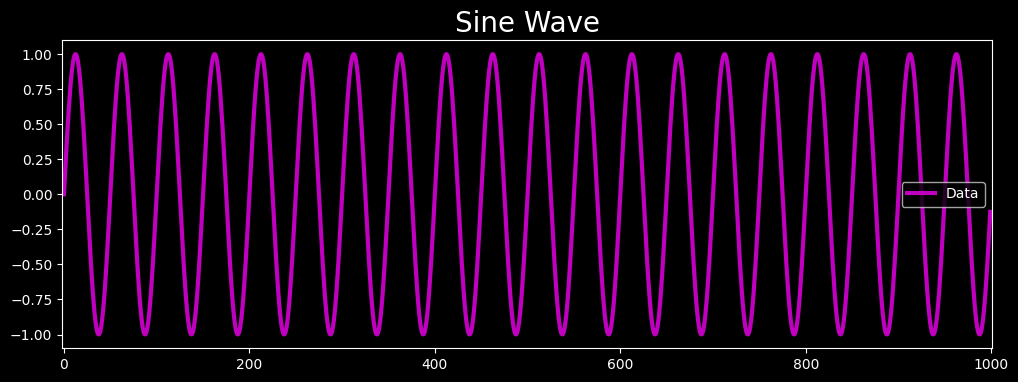

In [42]:
plt.figure(figsize=(12,4))
plt.xlim(-2,1001)
plt.plot(data.numpy(), 'm', lw =3, label = 'Data')
plt.title('Sine Wave', fontsize = 20)
plt.legend()
plt.show()

In [43]:
data.shape

torch.Size([1000])

In [44]:
data.numpy().shape

(1000,)

In [47]:
data_m = torch.zeros(N)
data_m[0:850] = data[0:850]
data_m[851:876] = 0
data_m[877:1000] = data[877:1000]

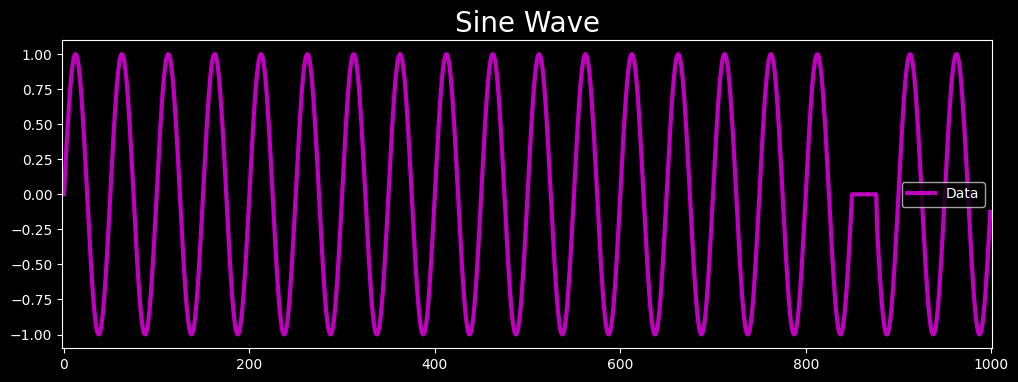

In [48]:
plt.figure(figsize=(12,4))
plt.xlim(-2,1001)
plt.plot(data_m.numpy(), 'm', lw =3, label = 'Data')
plt.title('Sine Wave', fontsize = 20)
plt.legend()
plt.show()

# Create an LSTM Model

In [49]:
class LSTM_model(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # Define  parameters

    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    # LSTM Layer

    self.lstm = nn.LSTM(input_size,num_hidden,num_layers)

    # Output Layer

    self.out = nn.Linear(num_hidden,1)

  def forward(self,x):

    y, (h,c) = self.lstm(x)
    out = self.out(y)

    return out, (h,c)

# Setting Parameters

In [50]:
input_size  =  1   # Feature dimension = D
hidden_size = 50
num_layers  =  1
seqlength   = 50   # T

# Create Model Instance and setting loss function and optimizer

In [51]:
model = LSTM_model (input_size,hidden_size,num_layers)
lossfunc = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model

LSTM_model(
  (lstm): LSTM(1, 50)
  (out): Linear(in_features=50, out_features=1, bias=True)
)

In [52]:
i = 0
X = data[i:i+seqlength]
y = data[i+seqlength]
print(X.shape)


torch.Size([50])


# Train the model

In [53]:
epochs = 20

losses = np.zeros(epochs)
for epoch in range(epochs):
   batchloss = []
   for i in range(N-seqlength):

    # We want to train like ([0,1,2,3,...,49],[50]), ([1,2,3,..,50],[51])....

        X = data_m[i:i+seqlength].view(seqlength,1,1) # seqlength X batchsize X input size
        y = data_m[i+seqlength].view(1,1) # y is the data element that follows X.

        ypred, (h, c) = model(X)
        loss = lossfunc(ypred[-1], y)
        batchloss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


   losses[epoch] = np.mean(batchloss)

   print(f'Epoch: {epoch} Loss: {loss.item():10.8f}')


Epoch: 0 Loss: 0.05786145
Epoch: 1 Loss: 0.03751280
Epoch: 2 Loss: 0.02000191
Epoch: 3 Loss: 0.00508262
Epoch: 4 Loss: 0.00035308
Epoch: 5 Loss: 0.00001774
Epoch: 6 Loss: 0.00000358
Epoch: 7 Loss: 0.00000234
Epoch: 8 Loss: 0.00000197
Epoch: 9 Loss: 0.00000166
Epoch: 10 Loss: 0.00000133
Epoch: 11 Loss: 0.00000102
Epoch: 12 Loss: 0.00000074
Epoch: 13 Loss: 0.00000051
Epoch: 14 Loss: 0.00000032
Epoch: 15 Loss: 0.00000018
Epoch: 16 Loss: 0.00000009
Epoch: 17 Loss: 0.00000003
Epoch: 18 Loss: 0.00000000
Epoch: 19 Loss: 0.00000000


# Visualizing Model Performance

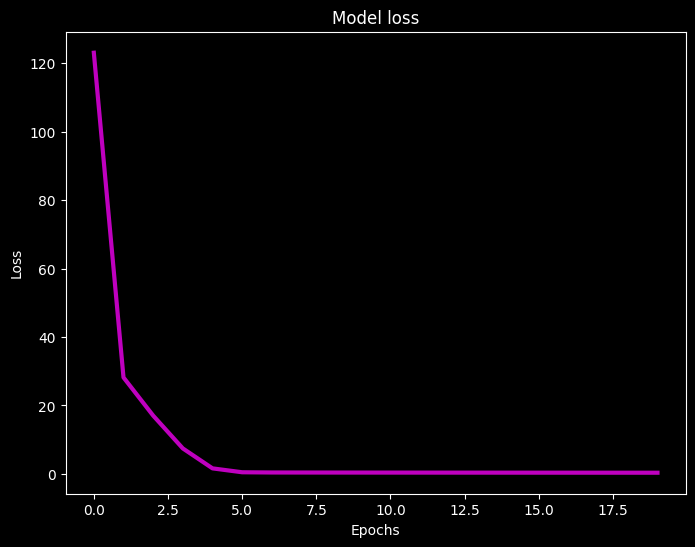

In [54]:
plt.figure(figsize = (8,6))
plt.plot(1000 * losses,'m', lw = 3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')

plt.show()

# Testing the Network (Interpolation)[Can be used to fill in the missing values]

In [58]:
yt = np.zeros(N)
for i in range(N-seqlength):

  # Getting the test data

  Xt = data[i:i+seqlength].view(seqlength,1,1)

  yt_pred, (h_t, c_t) = model(Xt)
  yt[i+seqlength] = yt_pred[-1]


# Visualization

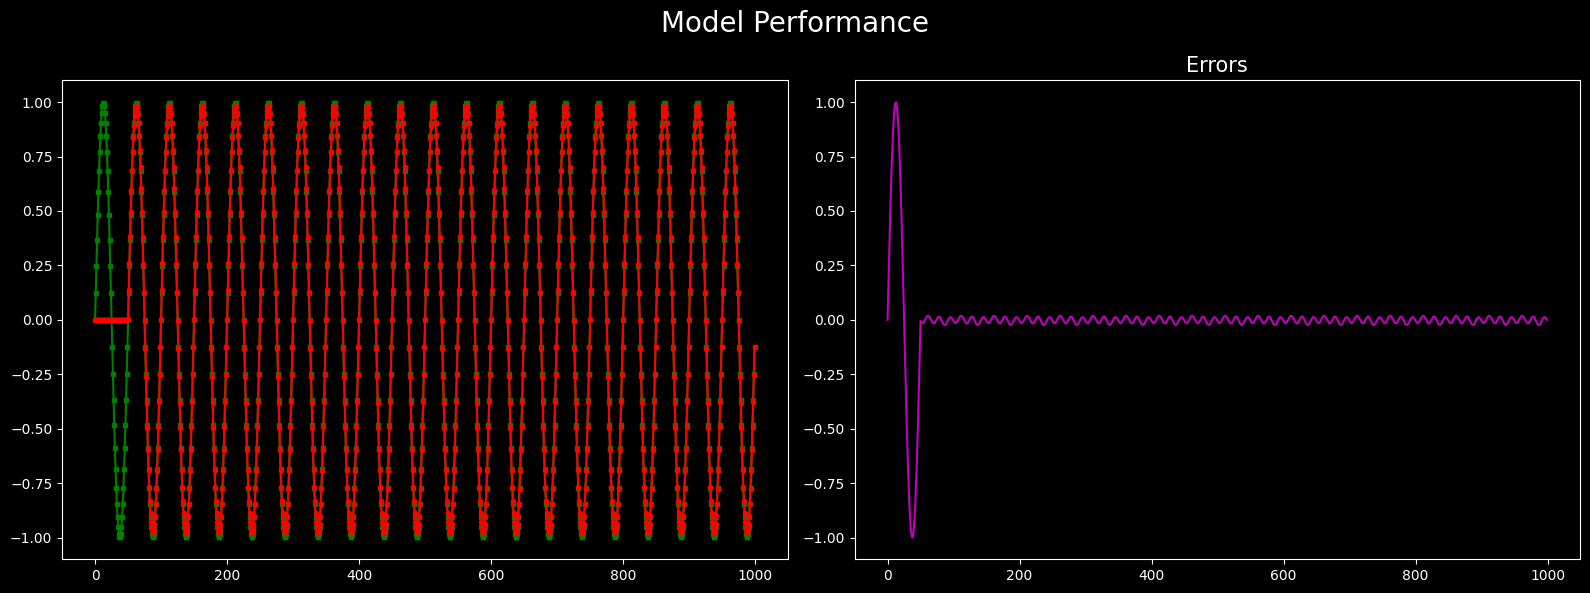

In [60]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(data,'gs-',label='Actual data',markersize=3)
ax[0].plot(yt,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
#ax[0].legend(fontsize = 15)

ax[1].plot(data-yt,'m')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors', fontsize = 15)


plt.suptitle('Model Performance', fontsize = 20)
plt.tight_layout()
plt.show()

# Discard First 50 samples from data and predicted data to observe interpolation

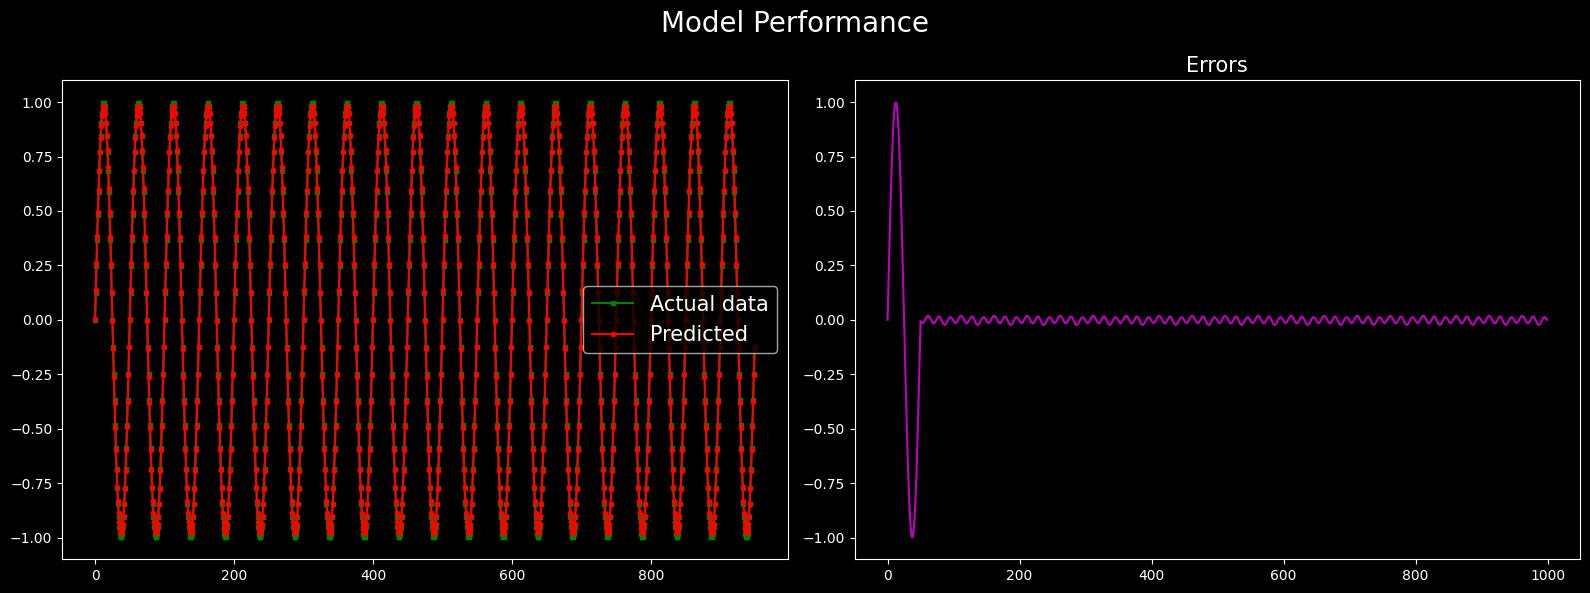

In [61]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(data[seqlength:],'gs-',label='Actual data',markersize=3)
ax[0].plot(yt[seqlength:],'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend(fontsize = 15)

ax[1].plot(data-yt,'m')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Erro', fontsize = 15)


plt.suptitle('Model Performance', fontsize = 20)
plt.tight_layout()
plt.show()

# Interpolation and Extrapolation

In [ ]:
seqlength = 50

# Create a data which is two times longer than the original data to perform extrapolation

yt = torch.zeros(2*N)
yt[:N] = data

for i in range(2*N-seqlength):

  X = yt[i:i+seqlength].view(seqlength,1,1)

  yt_pred, (h_t, c_t) = model(X)
  yt[i+seqlength] = yt_pred[-1]

  if ((i + 1) % 156) == 0.0:
      print(f' Iteration {i}/{2*N-seqlength}')
      plt.figure(figsize=(12,4))
      plt.xlim(0,2*N)
      plt.plot(data.numpy(),'m')
      plt.plot(range(N,2*N),yt.detach().numpy()[N:], 'pink')
      plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.xlim(0,2*N)
plt.plot(data.numpy(),'m')
plt.plot(range(N,2*N),yt.detach().numpy()[N:],'pink')
plt.show()


# Visualizing both Interpolation and Extrapolation

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.plot(data,'ys-',label='Actual data',markersize=3)
plt.plot(yt.detach().numpy(),'ro-',label='Predicted',markersize=3)
plt.ylim([-1.1,1.1])
plt.legend()
plt.title('Model Performance', fontsize = 20)
plt.show()